# Instruction 
## Release Notes
First release of the MLP_Fuelmap_SingleMap 2/14/2023 by wto@csustan.edu

### To train and predict the ML 
1. Load the Libraries from Fuelmap.ipynb first using %run Fuelmap.ipynb
2. Run the Train and Predict block. It will train the MLP with all of the non-zero tag data. Create the confusion matrix and print out the accuracies.

### To predict the fuelmap without training
1. Load the Libraries from Fuelmap.ipynb first using %run Fuelmap.ipynb
2. Run the Prediction Only Cell. This will run the prediction with the previously trained mlp. Create the confusion matrix and print out the accuracies.


In [1]:
# Load Libraries
%run Fuelmap.ipynb
## Defining cut parameters
RMSD_CUT = 10 #15.472021

Loaded LoadTrainingData()
Loaded RMS_of_band5x5()
Loaded PrintAcc()
Loaded SavePredictTif()


loading the data
unburnables tagged  2868
green grass tagged  6741
dry grass tagged  5478
greentree tagged  2152
dead trees tagged  1185
running mlp.fit
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


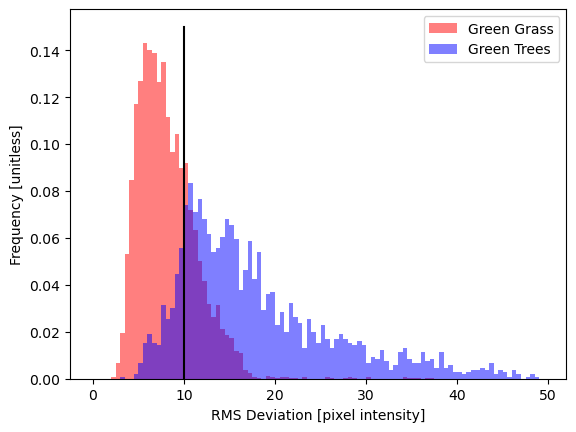

Creating the Confusion Matrix


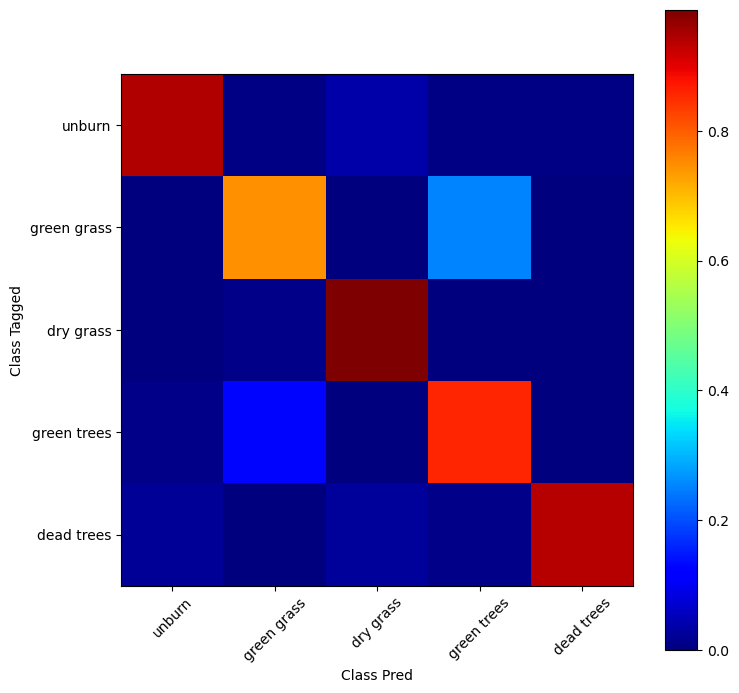

Unburnable: 94.4%
GreenGrass: 74.5%
DryGrass: 98.7%
GreenTree: 85.8%
DeadTree: 94.0%
Burnable: 85.4%
Overall: 86.9%
Saving as tif raster file
this took  454.464656829834 seconds


In [9]:
################### Training and Predict #########################################################
################### This block runs the Training (mlp.fit) then predict the classes for the entire map (mlp.predict)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#imageFile='/data/wto/AerialImages/hxip_m_3711961_ne_11_100.tif'
#tagFile='hxip_m_3711961_ne_11_100_wtag_Dec23.tif'
#outFile='hxip_m_3711961_ne_11_100_NNRMSD.tif'

imageFile='/data/wto/AerialImages/hxip_m_3711954_sw_11_100.tif'
tagFile='hxip_m_3711954_sw_11_100_wtag_Feb24.tif'
outFile='hxip_m_3711954_sw_11_100_NNRMSD.tif'

print("loading the data")
X_train, X_test, Y_train, Y_test, X_matrix, X_flat, Y_matrix, Y_flat = LoadTrainingData( imageFile,tagFile )

mlp = MLPClassifier(solver = 'sgd', learning_rate_init= 0.01, activation = 'relu', 
                    random_state = True, hidden_layer_sizes = [15,15,15,15])

print("running mlp.fit")
#print("Y_flat[Y_flat!=0].shape",Y_flat[Y_flat!=0].shape)
#Make a copy of Y_flat where 6 is retagged to 4.
Y_flat_64 = np.copy(Y_flat)
Y_flat_64[Y_flat_64==2]=4

mlp.fit(X_flat[Y_flat!=0],Y_flat_64[Y_flat_64!=0])
#print("Training Score %: ", mlp.score(X_train, Y_train)*100)
#print("Test Score %: ", mlp.score(X_test, Y_test)*100)

print("Running mlp.predict")
Y_predict = mlp.predict(X_flat)

print("Running RMSD Analysis")
Y_predict_matrix = np.reshape(Y_predict, X_matrix[0].shape)
NIR_RMS = RMSD_of_band5x5(X_matrix[3], Y_predict_matrix)

NIR_RMS_f = NIR_RMS.flatten()

print("Making the cut on RMSD")
NIR_RMS_4 = []
NIR_RMS_2 = []
for i in range(len(NIR_RMS_f)):
    if(Y_flat[i] == 4): NIR_RMS_4.append(NIR_RMS_f[i])
    if(Y_flat[i] == 2): NIR_RMS_2.append(NIR_RMS_f[i])  
    if ( NIR_RMS_f[i]<RMSD_CUT and Y_predict[i]==4 ):
        Y_predict[i]=2

rmsd_bins= np.arange(0,50,0.5)
plt.hist(NIR_RMS_2, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()     

############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat[Y_flat!=0],Y_predict[Y_flat!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['unburn', 'green grass','dry grass', 'green trees', 'dead trees']

fig = plt.figure(figsize = (8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,5.5,0.5,5.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix ###########

PrintAcc(Y_predict,Y_flat)
SavePredictTif(Y_predict,imageFile,outFile)
print('this took ', time.time()-start, 'seconds')

loading the data
unburnables tagged  20232
green grass tagged  2520
dry grass tagged  2775
greentree tagged  3404
dead trees tagged  2182
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


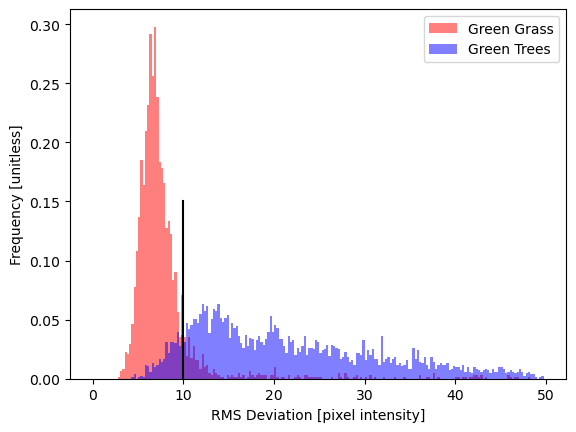

Creating the Confusion Matrix


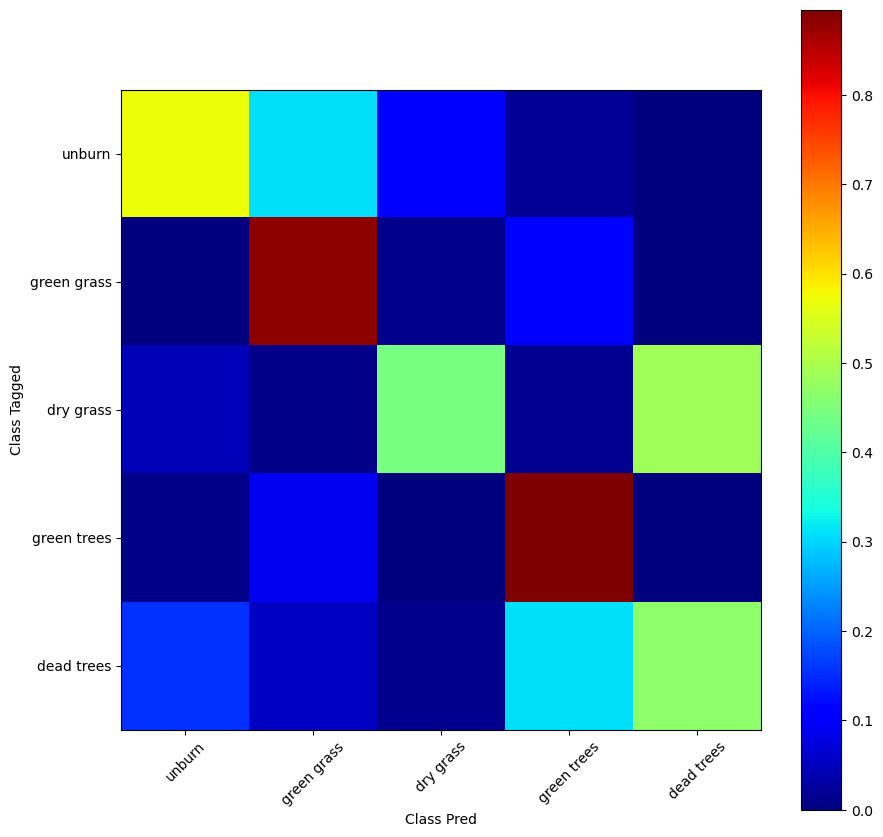

Unburnable: 57.0%
GreenGrass: 88.2%
DryGrass: 44.3%
GreenTree: 89.5%
DeadTree: 46.6%
Burnable: 74.7%
Overall: 62.3%
Saving as tif raster file
this took  525.5966138839722 seconds


In [11]:
################### Prediction Only Cell #########################################################
################### This block  predict the classes for the entire map (mlp.predict) (WITHOUT Training)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#define your input and output files
imageFile2='/data/wto/AerialImages/hxip_m_3711961_ne_11_100.tif'
tagFile2='hxip_m_3711961_ne_11_100_wtag_Dec23.tif'
outFile2='hxip_m_3711961_ne_11_100_NNRMSD.tif'

print("loading the data")
tmp, tmp, tmp, tmp, X_matrix2, X_flat2, Y_matrix2, Y_flat2  = LoadTrainingData( imageFile2,tagFile2)


print("Running mlp.predict")
Y_predict2 = mlp.predict(X_flat2)


print("Running RMSD Analysis")
Y_predict_matrix2 = np.reshape(Y_predict2, X_matrix2[0].shape)
NIR_RMS2 = RMSD_of_band5x5(X_matrix2[3], Y_predict_matrix2)

NIR_RMS_f2 = NIR_RMS2.flatten()

#print("Making the cut on RMSD")
#for i in range(len(NIR_RMS_f2)):
#    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
#        Y_predict2[i]=6

print("Making the cut on RMSD")
NIR_RMS2_4 = []
NIR_RMS2_2 = []
for i in range(len(NIR_RMS_f2)):
    if(Y_flat2[i] == 4): NIR_RMS2_4.append(NIR_RMS_f2[i])
    if(Y_flat2[i] == 2): NIR_RMS2_2.append(NIR_RMS_f2[i])  
    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
        Y_predict2[i]=2

rmsd_bins= np.arange(0,50,0.25)
plt.hist(NIR_RMS2_2, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS2_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()  
        
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat2[Y_flat2!=0],Y_predict2[Y_flat2!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['unburn', 'green grass','dry grass', 'green trees', 'dead trees']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,5.5,0.5,5.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix ###########

PrintAcc(Y_predict2,Y_flat2)
SavePredictTif(Y_predict2,imageFile2,outFile2)
print('this took ', time.time()-start, 'seconds')

In [ ]:
########## Probabilities Analysis from mlp.predict_proba()
### This code block makes the probability histogram using the training data.
targets = ['houses', 'road', 'asphalt', 'green trees', 'dead trees', 'dry grass', 'water','rock']
fulltargets =['houses', 'road', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

prob = mlp.predict_proba(X_train)

prob_1 = prob[Y_train==1]
prob_2 = prob[Y_train==2]
prob_3 = prob[Y_train==3]
prob_4 = prob[Y_train==4]
prob_5 = prob[Y_train==5]
prob_7 = prob[Y_train==7]
prob_8 = prob[Y_train==8]
prob_9 = prob[Y_train==9]

probabilities = [prob_1, prob_2, prob_3,prob_4,prob_5,prob_7,prob_8,prob_9]

print(len(probabilities))

def probability_graph(prob_matrix, class_num,ax):
    bins = np.linspace(0,1,10)
    matrix = np.zeros((len(bins)-1,8))

    for j in range(8):
        hist,edges =np.histogram(prob_matrix[:,j],bins=bins)
        matrix[:,j]=np.flip(hist)
    ax.imshow(matrix,extent=[0.5,8.5,0,100], aspect='auto', cmap="jet", norm=colors.LogNorm())
    ax.set_xticks([1,2,3,4,5,6,7,8])
    ax.set_xticklabels(targets)
    ax.set_title("Probability of Tagged {}:{} Log scale".format(class_num,fulltargets[class_num-1]))

fig , axes = plt.subplots(4,2,figsize=(20,20))
ax = axes.ravel()
classnumber = [1,2,3,4,5,7,8,9]
for i in range(8):
    probability_graph(probabilities[i],classnumber[i] , ax[i]) 